# Algoritmo de Búsqueda de Grover

In [20]:
import qiskit as q
import numpy as np

## Construcción del Oráculo

111


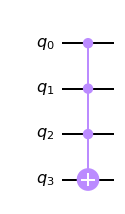

In [96]:
from random import random

def random_oracle(n):
    """
    Random oracla of a n-qubit register plus an ancillary qubit.
    """
    or_circuit = q.QuantumCircuit(n+1)
    
    inverted = []
    selected_state = ""
    for i in range(n):
        if random()>0.5:
            inverted.append(i)
            or_circuit.x(i)
            selected_state ="0"+ selected_state
        else:
            selected_state ="1"+ selected_state
    
    mc_gate = q.circuit.library.standard_gates.XGate().control(n)
    or_circuit.append(mc_gate,range(n+1))
    if len(inverted)>0:
        or_circuit.x(inverted)
    or_circuit.draw("mpl")
    #return or_circuit.to_gate(label="Oracle")
    return selected_state,or_circuit
answer, oracle = random_oracle(3)
print(answer)
oracle.draw("mpl")

In [97]:
print(answer)
statesim = q.Aer.get_backend('statevector_simulator')
ini_vec = [0]*8
for i in range(2**3):
    ini_vec[i] = 1
    print("input:" ,bin(i + 2**3)[3:])
    ini_circ = q.QuantumCircuit(4)
    ini_circ.initialize(ini_vec,range(3))
    ini_circ.initialize([np.sqrt(1/2),-np.sqrt(1/2)],3)
    oracle2 = ini_circ.compose(oracle)
    out = q.execute(oracle2,statesim).result().get_statevector()
    print(out.data[i],out.data[(i+8)%(2**4)])
    ini_vec[i] = 0

111
input: 000
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 001
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 010
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 011
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 100
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 101
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 110
(0.7071067811865476+0j) (-0.7071067811865476+0j)
input: 111
(-0.7071067811865476+0j) (0.7071067811865476+0j)


In [122]:
su = oracle.to_gate(label="$S_u$")

## Operador de dispersión

In [111]:
def S0(n):
    """
    
    """
    d_circuit = q.QuantumCircuit(n+1)
    
    inverted = []
    d_circuit.h(range(n))
    d_circuit.x(range(n))
    
    mc_gate = q.circuit.library.standard_gates.XGate().control(n)
    d_circuit.append(mc_gate,range(n+1))
    
    d_circuit.x(range(n))
    d_circuit.h(range(n))
    
    d_circuit.draw("mpl")

    return d_circuit

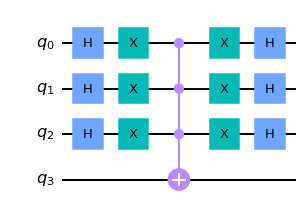

In [119]:
so = S0(3)
so.draw("mpl")

In [120]:
ini_vec = np.array([np.sqrt(2**-3)]*(2**3))

#ini_vec[4:] = -ini_vec[4:]
print(ini_vec)
ini_circ = q.QuantumCircuit(4)
ini_circ.initialize(ini_vec,range(3))
ini_circ.initialize([np.sqrt(1/2),-np.sqrt(1/2)],3)
s0_test = ini_circ.compose(s0)
out = q.execute(s0_test,statesim).result().get_statevector()
print(out.data)

[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
[-0.25-9.18485099e-17j -0.25-1.22464680e-16j -0.25-1.22464680e-16j
 -0.25-1.53080850e-16j -0.25-1.22464680e-16j -0.25-1.53080850e-16j
 -0.25-1.53080850e-16j -0.25-1.83697020e-16j  0.25+9.18485099e-17j
  0.25+1.22464680e-16j  0.25+1.22464680e-16j  0.25+1.53080850e-16j
  0.25+1.22464680e-16j  0.25+1.53080850e-16j  0.25+1.53080850e-16j
  0.25+1.83697020e-16j]


## Amplificación de amplitud


011


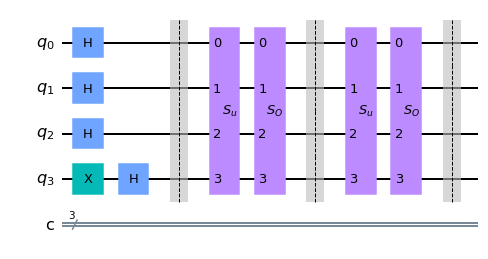

In [260]:
N = 3
s0 = S0(N).to_gate(label="$S_O$")
answer,su = random_oracle(N)
print(answer)
su = su.to_gate(label="$S_u$")
grover = q.QuantumCircuit(N+1,N)
grover.x(N)
grover.h(range(N+1))

grover.barrier()

reps = 2
for i in range(reps):
    grover.append(su,range(N+1))
    grover.append(s0,range(N+1))
    grover.barrier()
    
grover.draw("mpl")

In [261]:
out = q.execute(grover,statesim).result().get_statevector()
print(out)

Statevector([-0.0625-1.91351062e-17j, -0.0625-2.67891487e-17j,
             -0.0625-2.67891487e-17j,  0.6875+7.76885313e-16j,
             -0.0625-4.20972337e-17j, -0.0625-6.50593612e-17j,
             -0.0625-6.50593612e-17j, -0.0625-5.74053187e-17j,
              0.0625-1.14810637e-17j,  0.0625-3.82702125e-18j,
              0.0625-3.82702125e-18j, -0.6875-8.07501483e-16j,
              0.0625+1.14810637e-17j,  0.0625+3.44431912e-17j,
              0.0625+3.44431912e-17j,  0.0625+2.67891487e-17j],
            dims=(2, 2, 2, 2))


In [262]:
def target_proyection(u,target = "000"):
    index = 0
    for j in range(1,len(target)+1):
        if target[-j] == '1':
            index += 2**(j-1)
    return (u.data[index]-u.data[(index+2**len(target))% (2**(len(target)+1))])/np.sqrt(2)


In [263]:
print("Expected prob: ",np.abs(target_proyection(out,answer))**2)


Expected prob:  0.9453125000000017


## Simulación

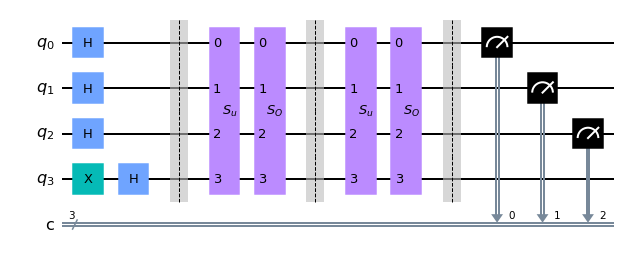

In [264]:
grover.measure(range(N),range(N))
grover.draw("mpl")


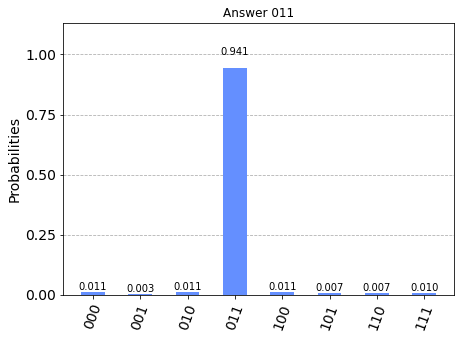

In [265]:
simulator = q.Aer.get_backend('aer_simulator')
trans = q.transpile(grover,simulator)
result = simulator.run(trans).result()
counts = result.get_counts(trans)
q.visualization.plot_histogram(counts, title='Answer '+answer)